# Packages

In [1]:
import datetime
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils
from keras.constraints import max_norm
from keras.constraints import MinMaxNorm
from keras.optimizers import RMSprop
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from scipy.stats import pearsonr

Using TensorFlow backend.


# Function definitions

## these correspond to functions $\cal{H}_1$ and $\cal{H}_2$ as described in Appendix A of (insert arxiv id)
## hh $\equiv \psi$ 
## aas $\equiv \alpha$ parameters
## d0p $\equiv \tilde{\alpha}$ parameters
## d1p $\equiv \beta$ parameters

In [2]:
def p1(): # a function to sample random numbers in [0,1]
    return random.random()

rseed=1500135045936 # with this seed the health function 1 has a good behaviour
random.seed(rseed)

hh = 1.2 # Health handle (parameter $\psi$ in article)
aas = list(map(lambda x: 10*random.random(),range(5)))
def P(x):
    a0 = sum(aas)/2
    return (np.abs((1/a0)*(a0 - sum([aas[k]*x[k] for k in range(5)]))))**(1/hh)
random.seed(rseed)

# hyperparameters d0 : 13 
d0p=list(map(lambda x: 2*random.random()-1,range(13)))

def d0(x):
    return np.exp(-np.abs(d0p[0]*x[13]+d0p[1]*x[5]+d0p[2]*x[6]+d0p[3]*x[7]+d0p[4]*x[8]) + np.abs(d0p[5]*x[9]+d0p[6]*x[6]+d0p[7]*x[10]+d0p[8]*x[11])+ np.abs(d0p[9]*x[12]+d0p[10]*x[13]+d0p[11]*x[5]+d0p[12]*x[14])/10)

# hyperparameters d1: 6 hyperparameters, numbers between -1 and 1.
random.seed(rseed)
d1p=list(map(lambda x: 2*random.random()-1,range(6)))

def d1(x):
    return 1 + 0.1*np.sin((d1p[0]*x[5]-np.abs(d1p[1]*x[8]+d1p[2]*x[9]+d1p[3]*x[10]))*(d1p[4]*x[0]*x[7]-d1p[5]*x[2]*x[14]))


def sv(ss): # define the gaussian centered at 1, with spread ss 
    return np.abs(np.random.normal(1, ss))

# to normalize, we first find the max value 
random.seed(rseed)
fvalues=[]
for k in range(500000):
    randpoint = list(map(lambda x: p1(),range(15)));
    fval = P(randpoint)*d0(randpoint)*d1(randpoint)
    fvalues.append(fval)
max0 = max(fvalues)
psh = np.poly1d([2*max0, max0])

# 
def totalfuncsh1(x,sh):    
    ff = P(x)*d0(x)*d1(x)*sv(sh);
    maxtot=psh(sh)
    if ff >= maxtot:
        return 1
    else:
        return ff/maxtot
    
    
# Function H_2

def fsh(x,y,sh):
    tmp = (1/15)*sv(sh)*abs(x[0]+(y[0]+3*y[1]-y[2])*(x[4]-x[2])+np.sinh(y[6]-y[5])-5*np.exp(-(y[8]-y[3])));
    if tmp > 1: tmp = 1;
    if tmp < 0: tmp = 0
    return tmp

def totalfuncsh2(x,sh):
    return fsh(x[:5],x[5:],sh)

# Other definitions

### rdtbest : samples ntrials drugs at random, then administers each to npatients/2, leaving the other npatients/2 with a placebo sample. Compares the average value of <H(x,y_trial)>  with those taking placebo <H(x,0)>. Function returns the list of drugs in their performing order, along with the list of (x,y) then used to train NN@RDT

In [3]:
# ntrials = how many trials 
# npatients = how many patients in each trial
# placebosize = 0.5 default value
def rdtbest(ntrials,npatients,placebosize=0.5): 
    drugs = [list(map(lambda x: p1(),range(10))) for k in range(ntrials)]
    trialdata=[]
    for dr in drugs:
        drpoints = []
        for p in range(npatients):
            if(p <= int(placebosize*npatients)):
                drpoints.append(list(map(lambda x: p1(),range(5))) + [0]*10)
            if(p > int(placebosize*npatients)):
                drpoints.append(list(map(lambda x: p1(),range(5))) + dr)
        trialdata.append(drpoints)    
    trialflat = []
    for tr in trialdata:
        trialflat += tr 
    fs = [list(map(lambda x: totalfuncsh(x,sh),tr)) for tr in trialdata]        
    favgsminus = []
    for f in fs:
        favgsminus.append(np.mean(f[int(placebosize*npatients):])-np.mean(f[:int(placebosize*npatients)]))
    favgsminus,drugs  = (list(t) for t in zip(*sorted(zip(favgsminus,drugs),reverse=True)))
    return drugs, trialflat 
#returns the drugs in the order that maximize <H(x,yn)> - <H(x,0)>.

#####################################################################

#Creates a fully connected NN with input dimension 15 and output dimension 1, from a list of integers ll
# Each of this integers corresponds to the number of neurons per hidden layer.
# ll = [10,2] corresponds to a NN with 4 layers, the input layer of 15, then two hidden layers of 10 and 2 neurons
# each, and finally the output neuron

# We use RELU activation for all layers.
# All hidden layers but the first one, and the output layer have biases set to zero
# This is done to prevent the NN from having a minimum different from zero

# We allow for dropout "drop" and learning rate "lr" parameters

def makemodel(ll,drop,lr):
    mm = Sequential()
    mm.add(Dense(input_dim=15, activation="relu", units=ll[0], kernel_initializer="normal"))
    mm.add(Dropout(drop))
    for l in ll[1:]:
        mm.add(Dense(activation="relu", units=l, kernel_initializer="normal",use_bias=False))
        mm.add(Dropout(drop))
    mm.add(Dense(activation="relu", units=1, kernel_initializer="normal",use_bias=False))
    mm.compile(optimizer=RMSprop(lr), loss='mse', metrics=['mae'])
    return mm

# This function trains the NN for regression.
# After fitting, it evaluates the NN in 20k points, to find the maximum values predicted by the NN
# Then, for each y in the top 1000 points that maximize the NN function, we evaluate the average value
# of the NN with fixed y, over a list of patients. We then use this average to sort the top-performing drugs
# and the function outputs the top 10. 

def NNmaximizer(trainset,model,epochs=1000,batch_size=None,val_split=0.2):
    if batch_size == None:
        batch_size = int(len(trainset)/25)
    yvalues = list(map(lambda x: totalfuncsh(x,sh),trainset))
    xvalues = np.array(trainset)
    mod = model
    history = mod.fit(xvalues, yvalues, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0); 
    testpo=[list(map(lambda x:p1(),range(15))) for k in range(20000)]
    nntestvals = mod.predict(np.array(testpo));
    l1, l2 = (list(t) for t in zip(*sorted(zip(nntestvals.tolist(),list(range(len(testpo)))),reverse=True)))
    #select top 1000 drugs, scan fs over them
    bestdrugs=[testpo[k][5:] for k in l2[:1000]]
    fsalldrg=[]
    for drg in bestdrugs:
        drgpat = [listpats[k] + drg for k in range(len(listpats))]
        fsdrg= mod.predict(np.array(drgpat));
        fsalldrg.append(np.mean(fsdrg))
    fsalldrg, bestdrugs = (list(t) for t in zip(*sorted(zip(fsalldrg,bestdrugs),reverse=True)))
    return mod, bestdrugs[:10],history


# These functions are for the tests of NN performance. They include Pearson R, Spearman R, Mean Squared Error, 
# and the AUC as a function of the threshold described in appendix B. 

def rspearman(sample, f, mod):
    truth_f = np.array(list(map(lambda x:f(x,sh),sample)))
    nn_f = np.array(mod.predict(np.array(sample))).T[0]
    return spearmanr(truth_f,nn_f)

def rpearson(sample, f, mod):
    truth_f = np.array(list(map(lambda x:f(x,sh),sample)))
    nn_f = np.array(mod.predict(np.array(sample))).T[0]
    return pearsonr(np.array(truth_f),np.array(nn_f))

def mse_test(sample, f, mod):
    truth_f = np.array(list(map(lambda x:f(x,sh),sample)))
    nn_f = np.array(mod.predict(np.array(sample))).T[0]
    return truth_f, nn_f, mean_squared_error(np.array(truth_f),np.array(nn_f))

def rocking_plot(sample, f, mod, threshold):
    truth_f = np.array(list(map(lambda x:f(x,sh),sample)))
    nn_f = np.array(mod.predict(np.array(sample))).T[0]
    truth_f_thr=np.where(truth_f > threshold, 1, 0)
    if(sum(truth_f_thr)==len(truth_f) or sum(truth_f_thr)==0.0):
        return [1.0,1.0,1.0], 1.0
    else:
        return roc_curve(truth_f_thr,nn_f), roc_auc_score(truth_f_thr,nn_f)

# Parameters for the run

## placebofrac : controls the fraction of placebo, to be used in RDT trials
## batchsize : controls how many patients per RDT trial.

## ntrials list: a list of ntrial numbers. Each ntrial defines an RDT trial with ntrial * batchsize total patients, testing over ntrial random drugs

## stochastics: a list of stochastic parameters, for each of the runs.

## models_list: a list of all the NN models to be tested.



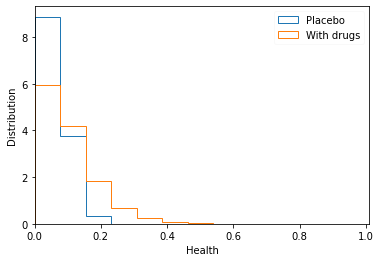

In [21]:
placebofrac = 0.5
batchsize = 100
random.seed(rseed)
listpats = [list(map(lambda x: p1(),range(5))) for k in range(10000)]


stochastics = [0.0,0.05,0.2,0.4]
ntrials_list = [5,10,20]

models_list=[[100, 32, 10, 10, 10, 10, 10, 10]]


## NN parameters
lr = 0.001 #learning rate
dropout= 0.1 # dropout
nepochs=1000 #number of epochs 

bins=np.linspace(0,1,15) # bins for the plotting of the Health distributions densities


## Selecting the health function between H1 and H2 
case = 1

if case == 1:
    totalfuncsh = totalfuncsh1
elif case == 2:
    totalfuncsh = totalfuncsh2
    
    
## A plot showing the expected distributions with and without drugs

placebox=[list(map(lambda x: p1(),range(5)))+[0]*10 for k in range(10000)]
drugx=[list(map(lambda x: p1(),range(15)))for k in range(10000)]
#bins=np.linspace(0,1,14)
fpl=list(map(lambda x:totalfuncsh(x,0.2),placebox))
fdr=list(map(lambda x:totalfuncsh(x,0.2),drugx))
plt.hist(fpl,histtype='step',density=True,bins=np.linspace(0,1,14),label='Placebo');
plt.hist(fdr,histtype='step',density=True,bins=np.linspace(0,1,14),label='With drugs');
plt.xlabel('Health');
plt.ylabel('Distribution');
plt.xlim([0,1.01]);
plt.legend(loc='upper right',framealpha=0.1);
plt.savefig('healthshape.png');
plt.show()    

# Loop running:

## running the following cell creates a folder "foldername"
## Inside it creates a log.txt file where it stores all data from each of the runs
## For each trial in ntrials, for each model in nmodels_list and for each noise value in stochastics, it generates the 4 types of plots present in the article

### * a plot of the Health distributions for each of the methods: (no drug, RDT, NN@RDT, NNDT) 
### * a plot of the Loss functions for both NN and NN@RDT, as a function of epochs, for train and validation sets.
### * a plot of NNoutput vs true Health, along with R and MSE values
### * a plot of AUC of tagging with NN as function of the threshold in true health function

In [8]:
foldername = "folder"
if(os.path.exists(foldername) == False):
    os.mkdir(foldername)
    
f=open(foldername+"/log.txt","a+")
f.write('Meta Parameters: \n')
f.write('f: case '+ str(case) + '\n')
f.write('dropout =' + str(dropout)+'\n')
f.write('learning rate = ' + str(lr) + '\n')
f.write('random seed: '+str(rseed)+'\n')
f.write('models are:'+str(models_list)+'\n');
f.write('\n');
f.close();

for ntrials in ntrials_list:
    for nmodlist,modlist in enumerate(models_list):
        nntrainset=[list(map(lambda x:p1(),range(15))) for k in range(ntrials*batchsize)]
        nntestset=[list(map(lambda x:p1(),range(15))) for k in range(int(ntrials*batchsize*0.5))];
        loopdrugs = []
        listsall = []
        meanvals = []
        for sh in stochastics:
            model = makemodel(modlist,drop=dropout,lr=lr)
            model2 = makemodel(modlist,drop=dropout,lr=lr)
            rdtdrugs, trialflat = rdtbest(ntrials,batchsize,placebosize=placebofrac)
            listbrdt= list(map(lambda x:totalfuncsh(x,sh),[listpats[k] + rdtdrugs[0] for k in range(len(listpats))]))
            listwrdt=list(map(lambda x:totalfuncsh(x,sh),[listpats[k]+ rdtdrugs[-1] for k in range(len(listpats))]))
            listwod=list(map(lambda x:totalfuncsh(x,sh),[listpats[k]+ [0]*10 for k in range(len(listpats))]))

            modeldrugsNN_fitted, modeldrugsNN,histNN=NNmaximizer(nntrainset,model,epochs=1000)
            modeldrugsNN_fitted_same, modeldrugsNN_same,histNN_same=NNmaximizer(trialflat,model2,epochs=1000)

            hists = [histNN,histNN_same]

            top10NNdt = [list(map(lambda x:totalfuncsh(x,sh),[listpats[k] + modeldrugsNN[u] for k in range(len(listpats))])) for u in range(10)]
            top10NNdt_same = [list(map(lambda x:totalfuncsh(x,sh),[listpats[k] + modeldrugsNN_same[u] for k in range(len(listpats))])) for u in range(10)]
            top10NNmeanf=list(map(lambda x:np.mean(x),top10NNdt))
            top10NNmeanf_same=list(map(lambda x:np.mean(x),top10NNdt_same))

            listNNDT = top10NNdt[0]
            listNNDT_same = top10NNdt_same[0]

            loopdrugs.append([rdtdrugs,modeldrugsNN,modeldrugsNN_same])
            listsall.append([listbrdt,listwrdt,listwod,listNNDT,listNNDT_same])
            meanvals.append(list(map(lambda x: np.mean(x),[listbrdt,listwrdt,listwod,listNNDT,listNNDT_same])))

            
            
            
            
            # plots:  
            
            
            plt.hist(listNNDT,label='Best NNDT',alpha=1,histtype='step',density=True,bins=bins);
            plt.hist(listNNDT_same,label='Best NN@RDT',alpha=1,histtype='step',density=True,bins=bins);
            plt.hist(listbrdt,label='Best RDT',alpha=1,histtype='step',density=True,bins=bins);
#            plt.hist(listwrdt,label='Worst RDT',alpha=1,histtype='step',density=True,bins=bins);
            plt.hist(listwod,label='No drugs',alpha=1,histtype='step',density=True,bins=bins,color='C4');
            plt.xlabel('Health');
            plt.ylabel('Distribution');
            plt.xlim([0,1.01]);
            #plt.ylim([0,1.01]);
            plt.legend(loc='upper right',framealpha=0.1);
            plt.title('Stochastic: '+str(int(100*sh))+'%');
            plt.savefig(foldername+"/f_distr_"+str(ntrials)+"_"+str(nmodlist)+"_"+str(sh)+".png");
            plt.close();
            x_mse,y_mse,val_mse = mse_test(nntestset,totalfuncsh,modeldrugsNN_fitted);
            plt.scatter(x_mse,y_mse,label='NN output',color='red');
            plt.plot(x_mse,x_mse,label='y = x', color='blue');
            aux_max=max(np.max(x_mse),np.max(y_mse))*1.025
            aux_min=min(np.min(x_mse),np.min(y_mse))*0.975
            plt.xlim([np.min(x_mse)*(0.975),np.max(x_mse)*1.025]);
            plt.ylim([aux_min,aux_max]);
            plt.xlabel('$\mathcal{H}$');
            plt.ylabel('$\mathcal{H}_{NN}$');
            plt.legend(loc='lower right',framealpha=0.1);
            rspear=round(rspearman(nntestset,totalfuncsh,modeldrugsNN_fitted)[0],4)
            plt.text(aux_min+0.2*(aux_max-aux_min), aux_min+0.65*(aux_max-aux_min), 'MSE ='+str(round(val_mse,4)), horizontalalignment='center', verticalalignment='center',fontsize=12);
            plt.text(aux_min+0.2*(aux_max-aux_min), aux_min+0.55*(aux_max-aux_min), 'Spearman R ='+str(rspear), horizontalalignment='center', verticalalignment='center',fontsize=12);
            plt.savefig(foldername+"/mse_"+str(ntrials)+"_"+str(nmodlist)+"_"+str(sh)+".png");
            plt.close();


            
            
            fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
            ax[0].plot(hists[0].history['loss'], label='loss')
            ax[0].plot(hists[0].history['val_loss'], label='val_loss')
            ax[0].legend(loc="upper right",framealpha=0.1)
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Loss')
            ax[0].set_xlim([0.,1000.])
            ax[0].set_title('NN with '+str(ntrials*batchsize)+' points')
            ax[1].plot(hists[1].history['loss'], label='loss')
            ax[1].plot(hists[1].history['val_loss'], label='val_loss')
            ax[1].legend(loc="upper right",framealpha=0.1)
            ax[1].set_xlabel('Epoch')
            ax[1].set_ylabel('Loss')
            ax[1].set_xlim([0.,1000.])
            ax[1].set_title('NN with '+str(ntrials*batchsize)+' points from RDT')
            plt.savefig(foldername+"/loss_"+str(ntrials)+"_"+str(nmodlist)+"_"+str(sh)+".png");
            plt.close();
            
            evaluated_f=np.array(list(map(lambda x:totalfuncsh(x,sh),nntestset)));
            thresholds=np.linspace(np.min(evaluated_f)*1.01,np.max(evaluated_f),100);
            aucs=list(map(lambda x:rocking_plot(nntestset,totalfuncsh,modeldrugsNN_fitted,x)[1],thresholds));
            plt.plot(thresholds,aucs);
            plt.xlabel("$w_t$");
            plt.ylabel("AUC");
            plt.xlim([np.min(evaluated_f)*1.01,1.01*np.max(evaluated_f)]);
            plt.ylim([0.49,1.01]);
            plt.savefig(foldername+"/auc_scan_"+str(ntrials)+"_"+str(nmodlist)+"_"+str(sh)+".png");
            plt.close();


            # PICKLING: 
      
            #pickle.dump( [[[listNNDT,listNNDT_same,listbrdt,listwrdt,listwod],bins],[x_mse,y_mse,val_mse,rspear],hists,[thresholds,aucs]], open(foldername+"/plots_"+str(ntrials)+"_"+str(nmodlist)+"_"+str(sh)+".pickle", "wb" ) ) # for saving

            # logging :
            
            f=open(foldername+"/log.txt","a+")
            f.write('\n');
            f.write('--------------------------------- \n')
            f.write(str(datetime.datetime.now())+'\n \n');
            f.write('[ntrials,modlist,sh]: \n')
            f.write('['+str(ntrials)+','+str(modlist)+','+str(sh)+']')
            f.write('\n')
            f.write('model params: '+str(model.count_params()))
            f.write('\n')
            f.write('best NN mean: ' + str(np.mean(listNNDT))+'\n')
            f.write('best NN (RDT train data) mean: ' + str(np.mean(listNNDT_same))+'\n')
            f.write('best RDT mean: ' + str(np.mean(listbrdt))+'\n')
            f.write('worst RDT mean: ' + str(np.mean(listwrdt))+'\n')
            f.write('no drug mean: ' + str(np.mean(listwod))+'\n')
            f.write('MSE: ' + str(val_mse)+'\n')
            f.write('R Spearman: ' + str(rspearman(nntestset,totalfuncsh,modeldrugsNN_fitted))+'\n')
            f.write('R Pearson: ' + str(rpearson(nntestset,totalfuncsh,modeldrugsNN_fitted))+'\n')
            f.close()
 


# In[ ]:


f=open(foldername+"/log.txt","a+");
f.write('\n');
f.write('The End')
f.close();


